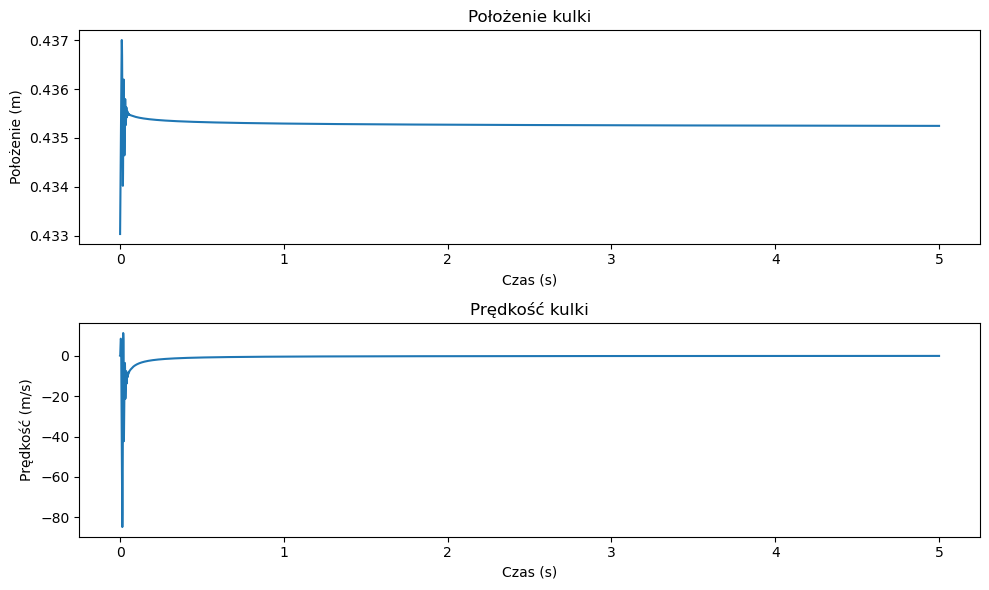

In [70]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numba


# Definicje stałych
frequency = 40000  # Hz
wavelength = 343 / frequency  # m
amplitude = 400  # Zwiększona amplituda
rho_air = 1.225  # kg/m^3
c_air = 343  # m/s
mu_air = 1.82e-5  # Pa*s
radius = 0.001  # m
rho_particle = 0.01  # kg/m^3
c_particle = 900  # m/s
mass = (4/3) * np.pi * radius**3 * rho_particle  # kg

# Współczynniki potencjału Gorkova
K1 = (1 / (4 * np.pi * c_air**2 * rho_air)) * (1 - (rho_air / rho_particle))
K2 = (1 / (8 * np.pi * c_air**2 * rho_air)) * ((rho_particle - rho_air) / (2 * rho_particle + rho_air))

# Funkcja potencjału Gorkova z modyfikacją amplitudy efektywnej
@numba.njit
def gorkov_potential(z, transducer_distance):
    k = 2 * np.pi / wavelength
    amplitude_effective = amplitude * (1 + np.cos(k * (transducer_distance - 2*z)))
    return (4 / 3) * np.pi * radius**3 * (K1 * amplitude_effective**2 * (np.cos(2 * k * z) - 1) + 3 * K2 * amplitude_effective**2 * np.cos(2 * k * z))

# Równanie ruchu kulki
@numba.njit
def ball_motion(state, dt, transducer_distance):
    z, v = state
    
    k = 2 * np.pi / wavelength
    d_gorkov_potential_dz = -(8 / 3) * np.pi * radius**3 * K1 * amplitude**2 * k * np.sin(2 * k * z) * (1 + np.cos(k * (transducer_distance - 2 * z)))
    acoustic_force_gradient = d_gorkov_potential_dz
    drag_force = -6 * np.pi * mu_air * radius * v
    gravity_force = -mass * 9.81
    total_force = acoustic_force_gradient + drag_force + gravity_force  # Odkomentowane, aby uwzględnić wszystkie siły
    dv_dt = total_force / mass
    dz_dt = v
    return [z+dz_dt*dt, v+dv_dt*dt]


# Warunki początkowe i symulacja
z0 = 50.5*wavelength  # Zmienione położenie początkowe na połowę długości fali
v0 = 0  # m/s
state0 = [z0, v0]
transducer_distance = 100*wavelength  # Odległość między transducerami ustawiona na połowę długości fali
t = np.linspace(0, 5, 1000000)
solution = odeint(ball_motion, state0, t, args=(transducer_distance,))
#state_history = [state0]
#for i,t_i in enumerate(t[:-1]):
#    state_history.append(ball_motion(state_history[-1],t[1]-t[0],transducer_distance))
    
#state_history = np.array(state_history)
# Wykresy
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('Położenie kulki')
plt.xlabel('Czas (s)')
plt.ylabel('Położenie (m)')

plt.subplot(2, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('Prędkość kulki')
plt.xlabel('Czas (s)')
plt.ylabel('Prędkość (m/s)')

plt.tight_layout()
plt.show()
gi